In [1]:
import gc
from collections import defaultdict
from itertools import combinations

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from nilearn.image import load_img, math_img, new_img_like
from nilearn.plotting import plot_roi, plot_stat_map
from scipy.ndimage import label

from survey_medley_code.config_loader import load_config

# Reviewing the results
In this notebook the Omnibus F-test map is shown (corrected for multiple comparisons) and then I attempt to relate it to the individual pairwise t-tests. It is important to realize that just because the F-test is significant, we're not guaranteed to have a significant difference in individual paired comparisons between questionnares.

**Omnibus F-test**: Detects whether there is any difference among the group means at a voxel.
* Significant F means: there is some effect in the voxel, but it doesn’t specify which pairs differ.
* It can be significant even if none of the pre-defined pairwise contrasts reach the threshold individually — for example, when small, distributed differences combine to give a significant F.

**Pairwise T-tests**: Examine specific differences between two conditions/contrasts.
* Significant T means: that specific contrast differs.
* T-tests can be non-significant even where F is significant, especially if effects are small and distributed.

## Layout of notebook
1. **Omnibus F-test result**
2. **Paired comparisons (all questionnaire pairs)**
3. **Relating paired comparisons to Omnibus F result**

In [2]:
cfg = load_config()

In [3]:
outdir = cfg.output_root / 'within_subject_question_estimates'

In [4]:
omnibus_pmap_file = outdir / 'group_f_test/glm_tfce_1minuspvalue_fstat_omnibusf.nii.gz'
omnibus_fmap_file = outdir / 'group_f_test/glm_fstat_omnibusf.nii.gz'

paired_outdir = outdir / 'all_paired_t_tests'

### 1. Omnibus F-test results

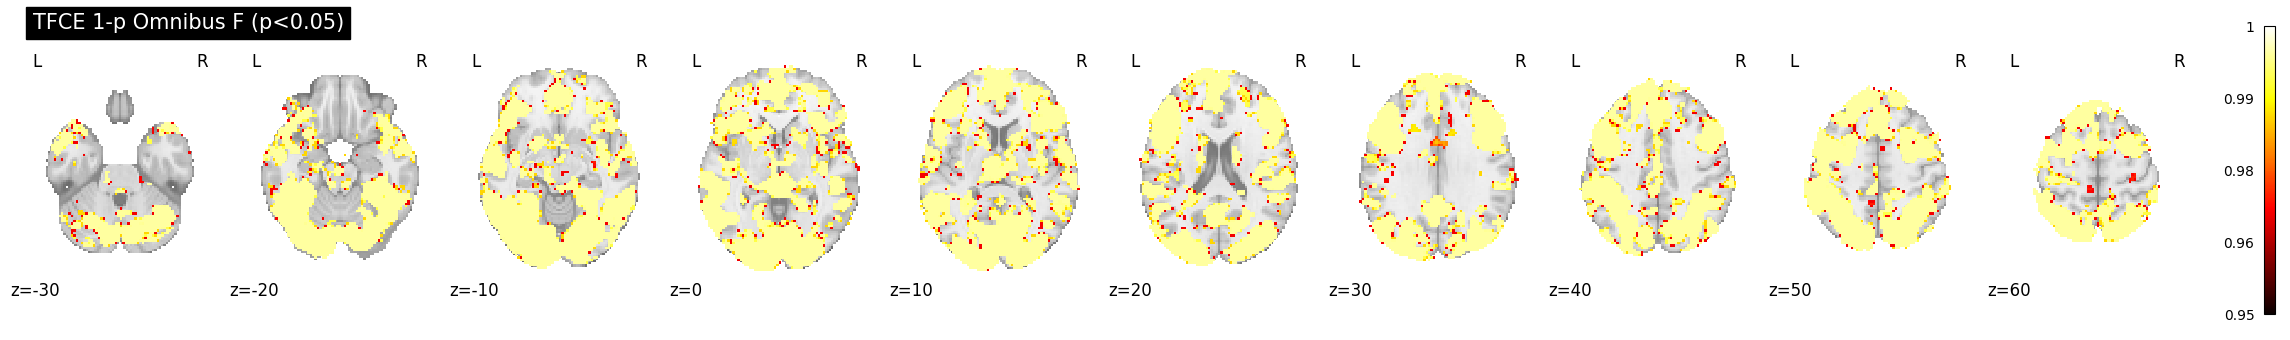

In [5]:
# omnibus = load_img(omnibus_pmap_file)

z_slices = list(range(-30, 61, 10))
threshold = 0.95

plot_stat_map(
    omnibus_pmap_file,
    threshold=threshold,
    display_mode='z',
    cut_coords=z_slices,
    colorbar=True,
    vmin=0.95,
    vmax=1.005,
    symmetric_cbar=False,
    cmap='hot',
    title=f'TFCE 1-p Omnibus F (p<{(1 - threshold):.2f})',
)
plt.show()

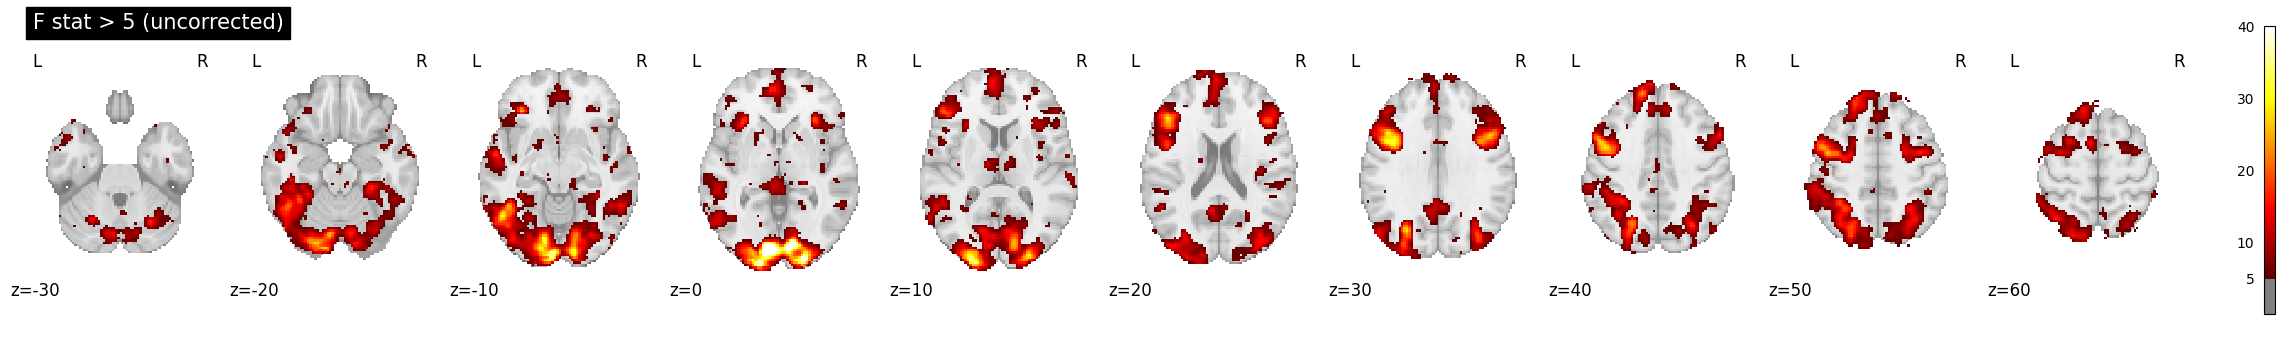

In [6]:
fthresh = 5

plot_stat_map(
    omnibus_fmap_file,
    threshold=fthresh,
    display_mode='z',
    cut_coords=z_slices,
    colorbar=True,
    title=f'F stat > {fthresh} (uncorrected)',
    vmin=0,
    vmax=40,
    symmetric_cbar=False,
    cmap='hot',
)
plt.show()

### 2. Paired comparisons (all questionnaire pairs)

In [7]:
questionnaire_names = ['brief', 'future_time', 'grit', 'impulsive_venture', 'upps']

question_pmaps = {}
question_tmaps = {}

for qa, qb in combinations(questionnaire_names, 2):
    pairing_name = f'{qa}_minus_{qb}'
    paired_pmap_loop = (
        paired_outdir
        / f'paired_test_{pairing_name}/onesample_2sided_tfce_corrp_fstat1.nii.gz'
    )
    paired_t_loop = (
        paired_outdir / f'paired_test_{pairing_name}/uncorrected_tstat1.nii.gz'
    )

    question_pmaps[pairing_name] = paired_pmap_loop
    question_tmaps[pairing_name] = paired_t_loop


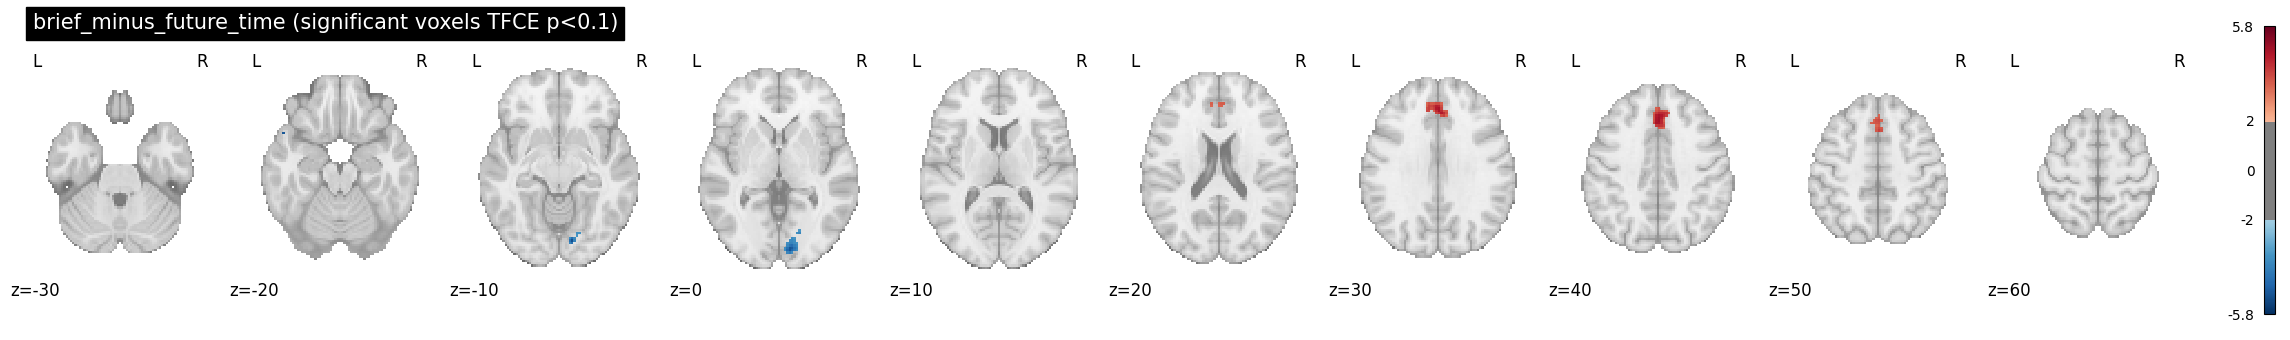

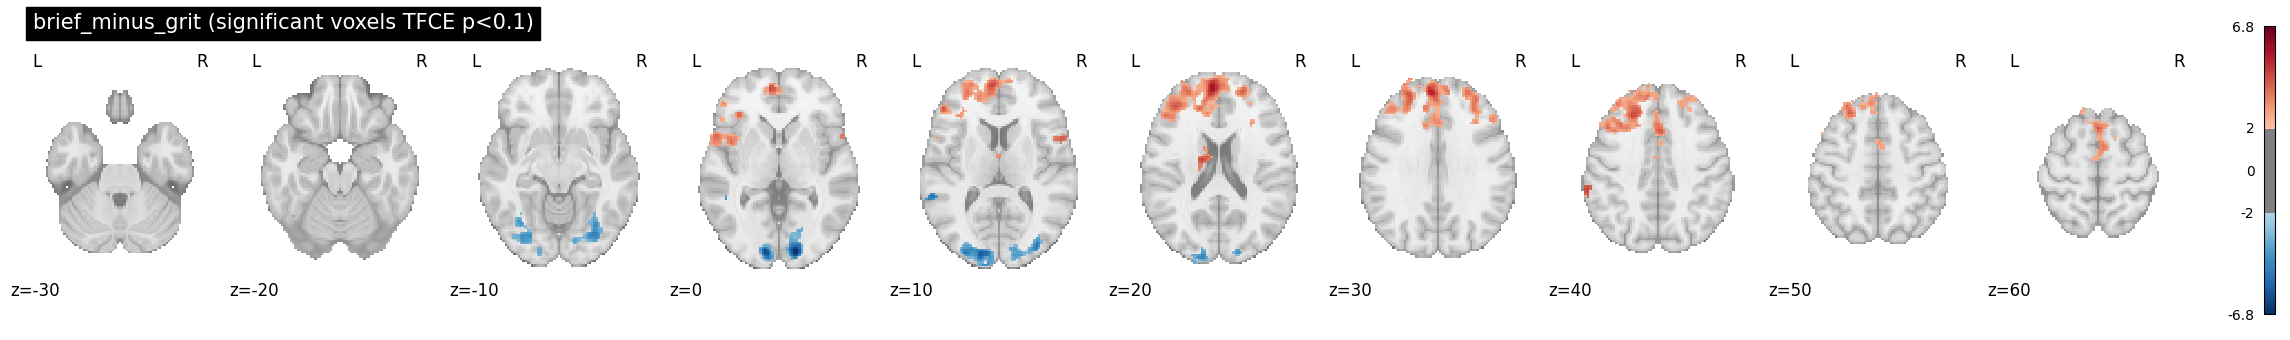

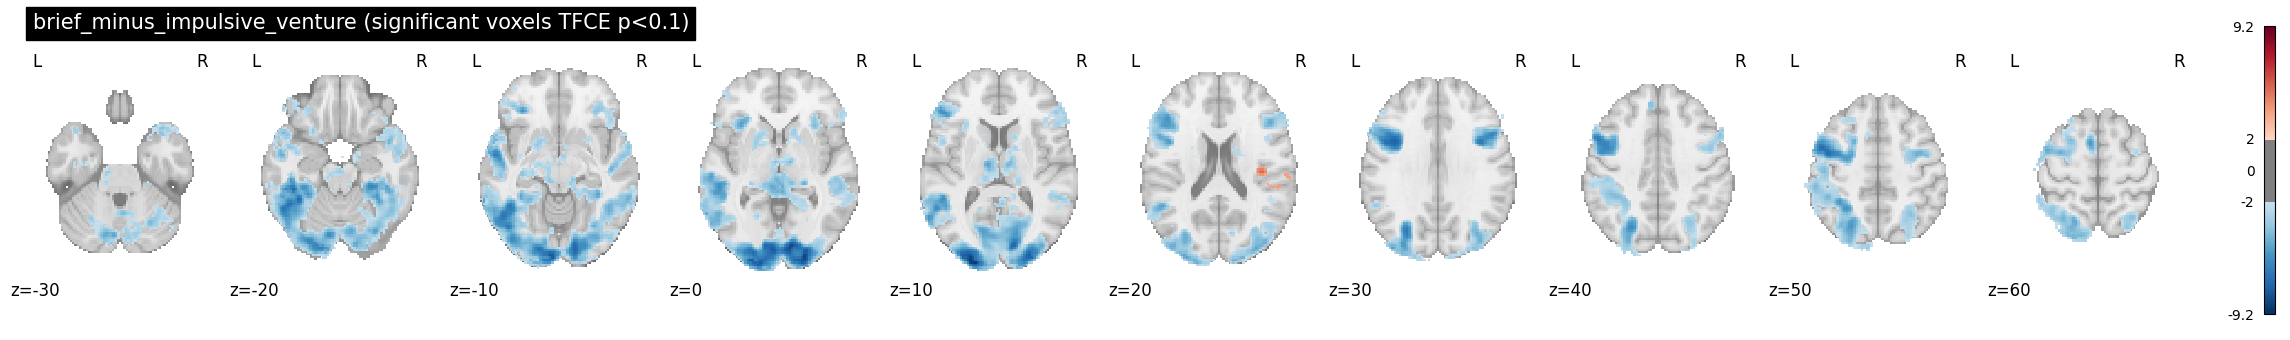

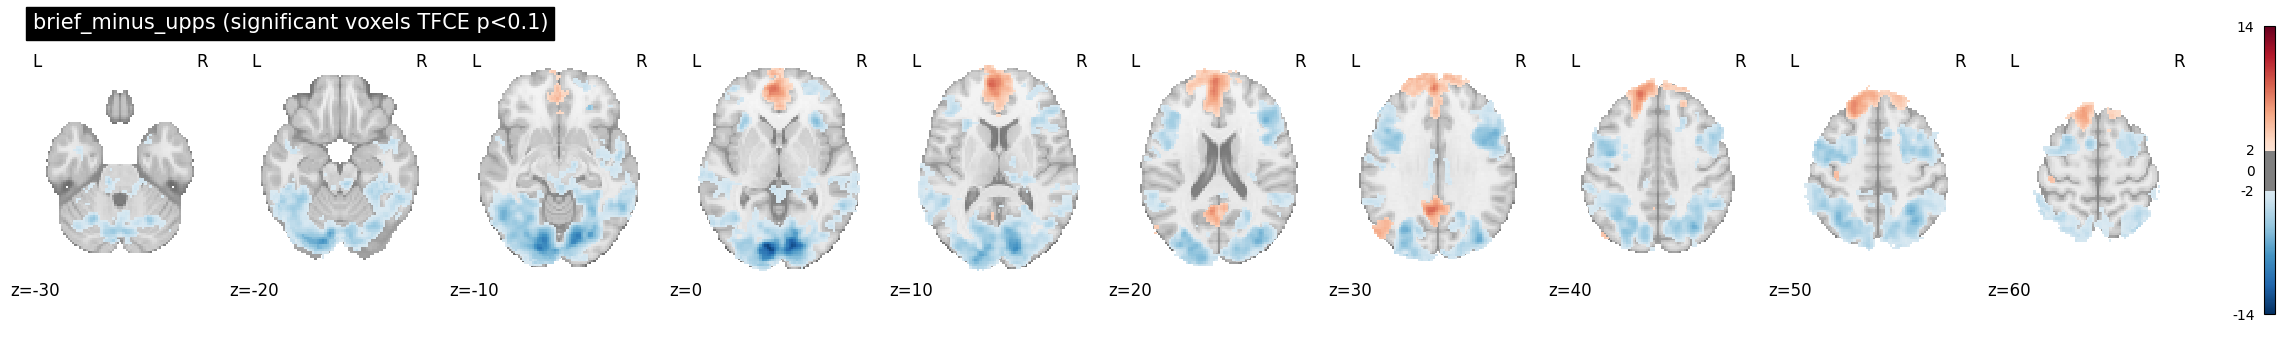

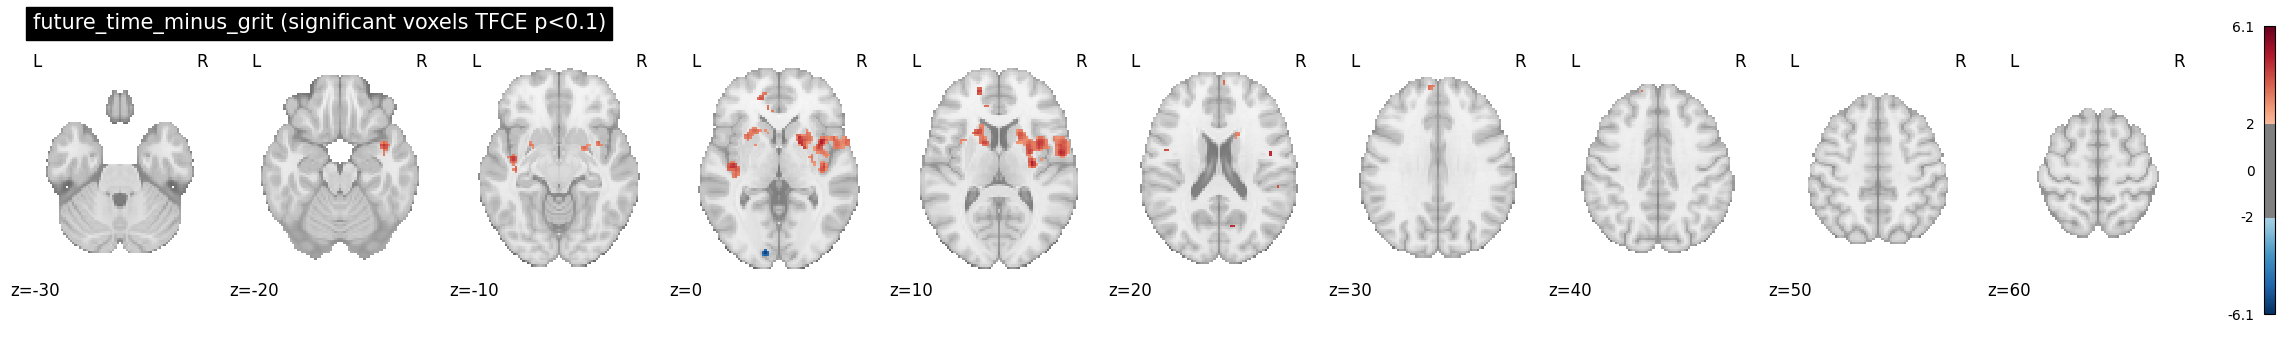

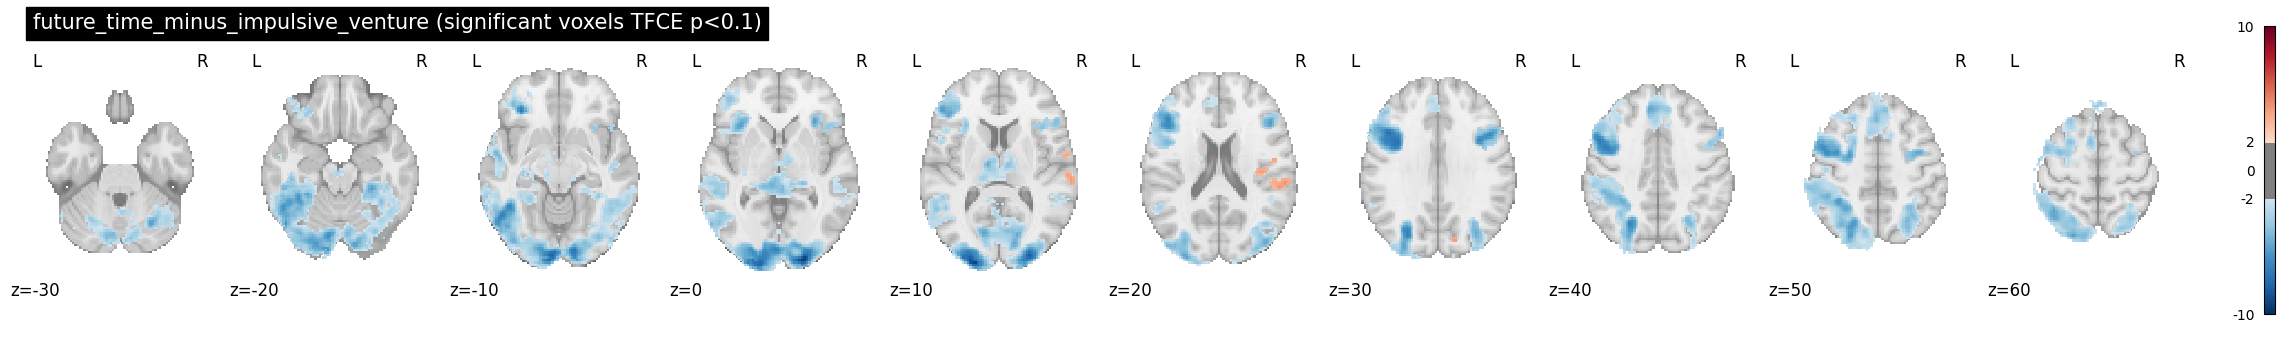

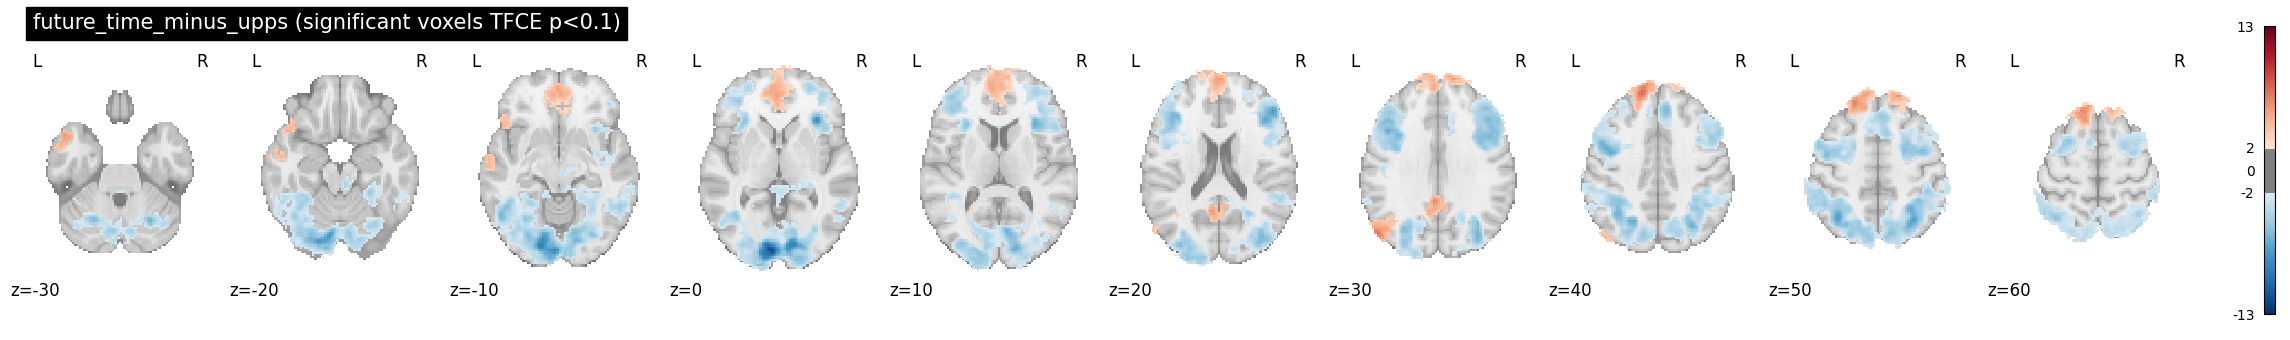

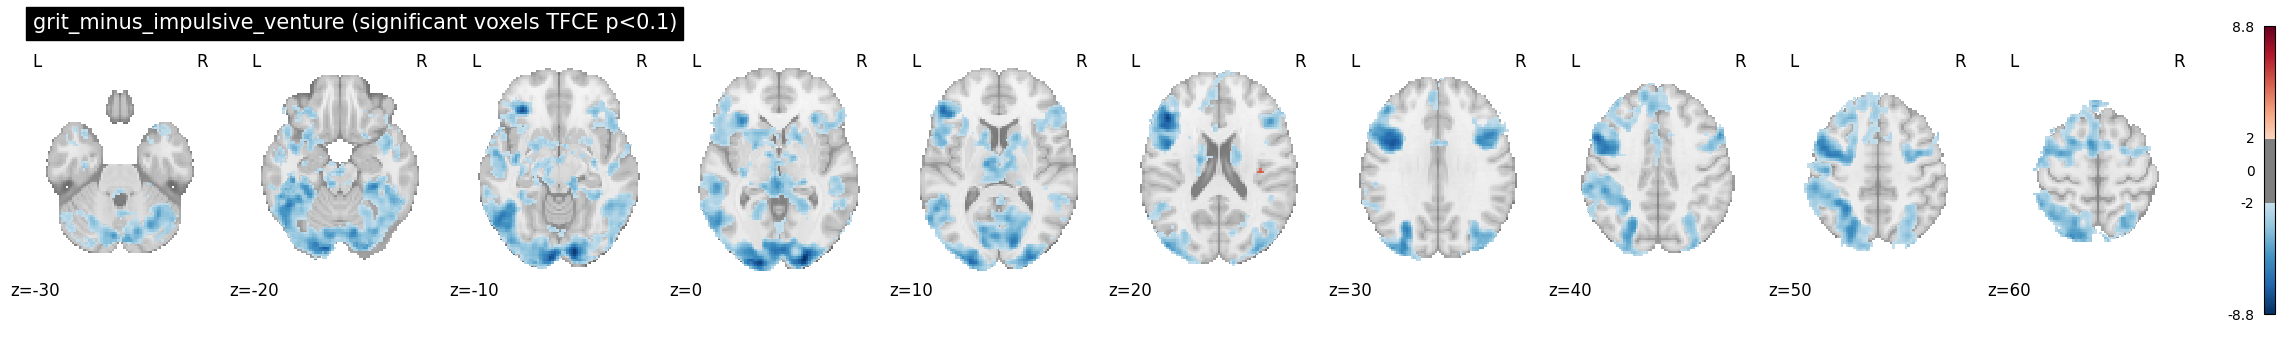

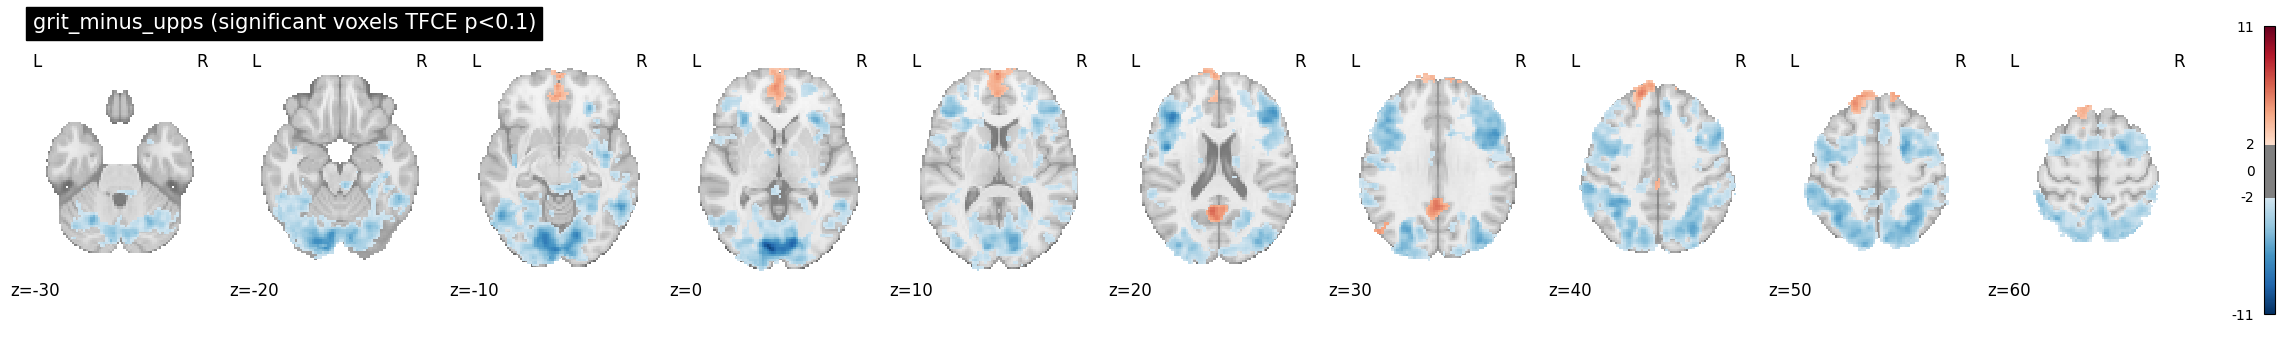

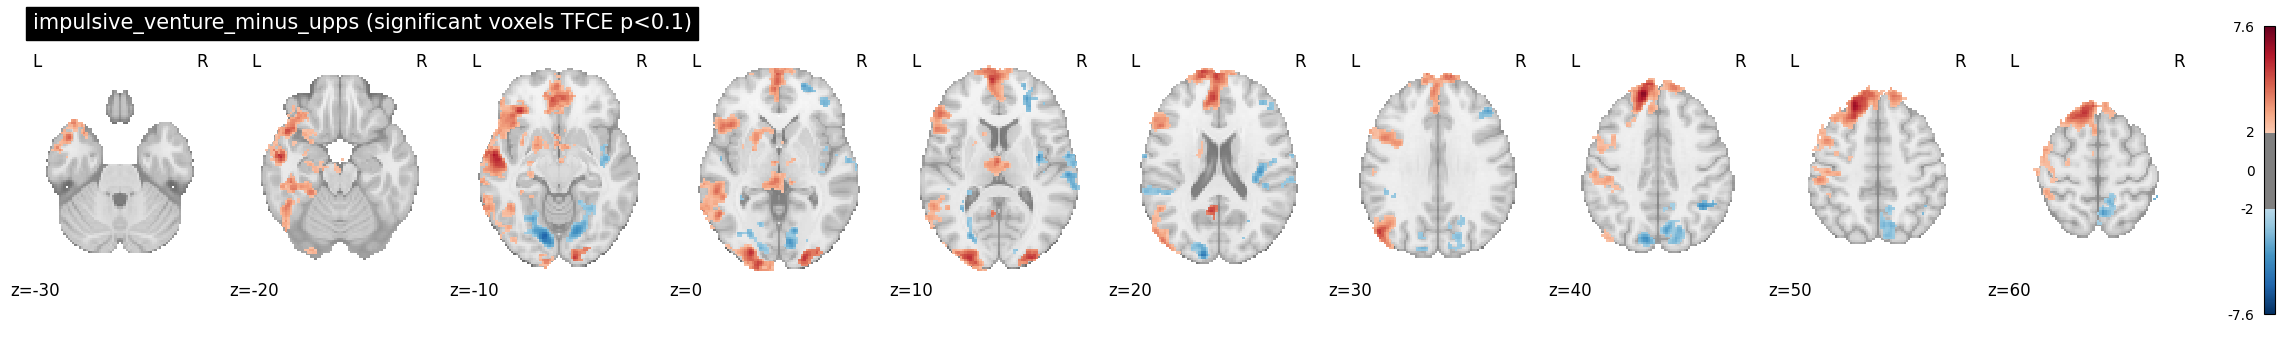

In [8]:
bon_thresh = 1 - (0.1)

binary_paired_maps = {}

for map_label, map in question_pmaps.items():
    tmap = load_img(question_tmaps[map_label])
    pmap = load_img(map)
    # Threshold and binarize pmap at 0.95, then multiply by fmap
    img = math_img(f'img_t * (img_p > {bon_thresh})', img_t=tmap, img_p=pmap)

    # Create positive and negative binary maps
    pos_binary = math_img('img > 0', img=img)
    neg_binary = math_img('img < 0', img=img)

    pos_key = map_label.replace('_minus_', ' > ')
    binary_paired_maps[pos_key] = pos_binary

    # Negative map
    neg_key = map_label.replace('_minus_', ' < ')
    binary_paired_maps[neg_key] = neg_binary

    display = plot_stat_map(
        img,
        threshold=2,
        display_mode='z',
        cut_coords=z_slices,
        colorbar=True,
        title=f'{map_label} (significant voxels TFCE p<{1 - bon_thresh:.3})',
    )
    plt.show()
    display.close()

In [9]:
gc.collect()


20940

### 3. Relating paired comparisons to Omnibus F result

For each paired comparison, we identify the voxels that are significant in both the pairwise t-test and the omnibus F-test. This procedure is repeated for all paired comparisons. For each voxel, an integer encodes which paired comparisons are significant at that location.

Although there are many possible combinations (we split the 10 comparisons into positive and negative directions, giving 20 possibilities), if I restrict to overlaps that have a least one connected component with > 150 voxels, there aren't too many to plot.

In [10]:
# binary_paired_maps: dictionary of binary maps
binary_f_map = math_img('img > .95', img=omnibus_pmap_file)

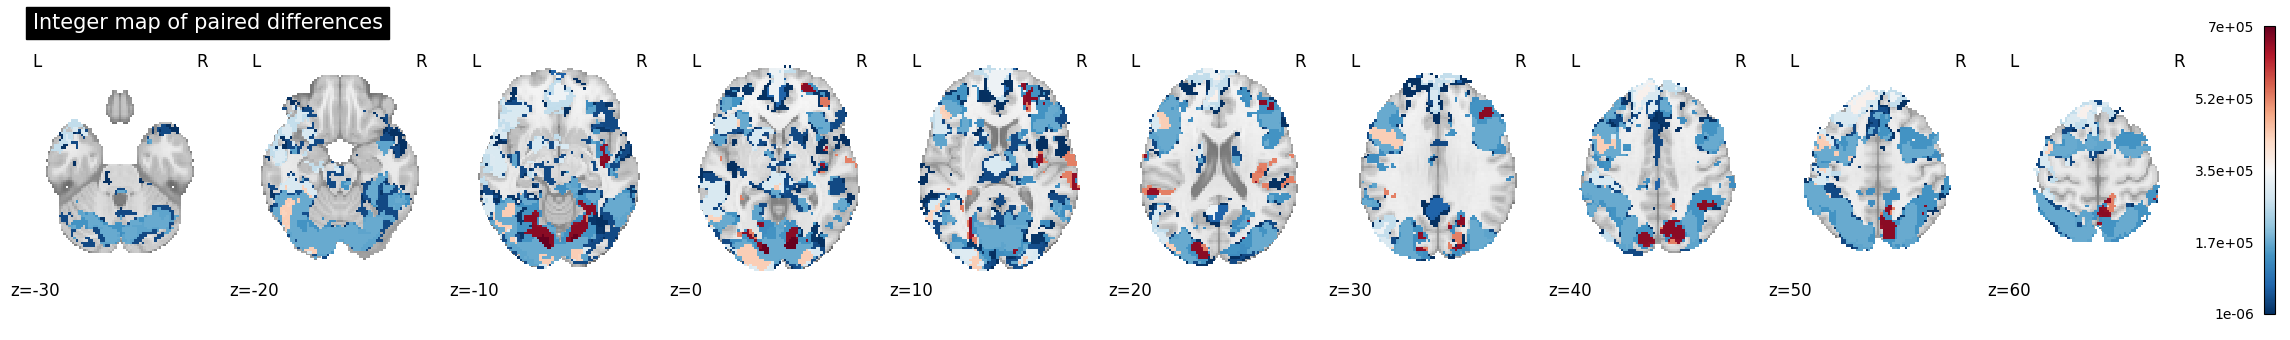

In [11]:
pair_names = list(binary_paired_maps.keys())
n_pairs = len(pair_names)

# Create an empty integer map
data_shape = binary_f_map.shape
integer_map = np.zeros(data_shape, dtype=np.int32)

# Loop through each pair and set the corresponding bit
for bit_idx, pair in enumerate(pair_names):
    pair_data = binary_paired_maps[pair].get_fdata()
    pair_data_bin = (pair_data > 0).astype(np.int32)  # ensure 0 or 1
    integer_map += pair_data_bin * (2**bit_idx)

# Mask to include only voxels significant in the omnibus F
f_data = binary_f_map.get_fdata()
integer_map = integer_map * (f_data > 0).astype(np.int32)

# Create a new Nifti image
integer_img = new_img_like(binary_f_map, integer_map)

# Plot the integer map (hard to tell what is waht)
plot_stat_map(
    integer_img,
    title='Integer map of paired differences',
    display_mode='z',
    cut_coords=z_slices,
)
plt.show()


In [12]:
# Count number of unique values and voxel counts
unique_vals, counts = np.unique(integer_map, return_counts=True)
voxel_counts = dict(zip(unique_vals, counts))
# print('Voxel counts for each combination:')
# for val, count in voxel_counts.items():
#     print(f'Integer {val}: {count} voxels')

# Create a dictionary to interpret integer values
interpret_dict = {}
for val in unique_vals:
    included_pairs = [pair_names[i] for i in range(n_pairs) if (val >> i) & 1]
    if not included_pairs:
        included_pairs = [
            'F only'
        ]  # category for F-significant voxels with no paired difference
    interpret_dict[val] = included_pairs


In [13]:
def generate_summary_title(pairs):
    less_than = defaultdict(set)
    greater_than = defaultdict(set)
    all_elements = set()

    for pair in pairs:
        left, right = pair.split(' < ' if ' < ' in pair else ' > ')
        all_elements.add(left)
        all_elements.add(right)
        if ' < ' in pair:
            less_than[left].add(right)
            greater_than[right].add(left)
        else:
            less_than[right].add(left)
            greater_than[left].add(right)

    def find_longest_chain(start, chain=None):
        if chain is None:
            chain = [start]
        if start not in less_than:
            return chain
        next_elements = less_than[start]
        longest = chain
        for next_elem in next_elements:
            if next_elem not in chain:
                new_chain = find_longest_chain(next_elem, chain + [next_elem])
                if len(new_chain) > len(longest):
                    longest = new_chain
        return longest

    longest_chain = max((find_longest_chain(start) for start in all_elements), key=len)

    set_relations = []
    for elem in all_elements:
        if len(greater_than[elem]) > 1:
            set_relations.append(
                f'{{{", ".join(sorted(greater_than[elem]))}}} < {elem}'
            )
        if len(less_than[elem]) > 1:
            set_relations.append(f'{elem} < {{{", ".join(sorted(less_than[elem]))}}}')

    summary = []
    if len(longest_chain) > 2:
        summary.append(' < '.join(longest_chain))
    summary.extend(set_relations)

    if not summary:
        for left, rights in less_than.items():
            for right in rights:
                summary.append(f'{left} < {right}')

    # Additional summarization step
    def parse_set(s):
        return set(s.strip('{}').split(', '))

    new_summary = []
    left_groups = defaultdict(set)
    right_groups = defaultdict(set)

    for relation in summary:
        parts = relation.split(' < ')
        if len(parts) == 2:  # Only process binary relations
            left, right = parts
            if left.startswith('{') and right.startswith('{'):
                left_set, right_set = parse_set(left), parse_set(right)
                left_groups[frozenset(right_set)].update(left_set)
                right_groups[frozenset(left_set)].update(right_set)
            elif left.startswith('{'):
                left_set = parse_set(left)
                left_groups[right].update(left_set)
            elif right.startswith('{'):
                right_set = parse_set(right)
                right_groups[left].update(right_set)
            else:
                new_summary.append(relation)
        else:  # This is likely the longest chain
            new_summary.append(relation)

    for right, lefts in left_groups.items():
        if isinstance(right, frozenset):
            new_summary.append(
                f'{{{", ".join(sorted(lefts))}}} < {{{", ".join(sorted(right))}}}'
            )
        else:
            new_summary.append(f'{{{", ".join(sorted(lefts))}}} < {right}')

    for left, rights in right_groups.items():
        if isinstance(left, frozenset):
            if not any(
                set(rights).issubset(parse_set(r.split(' < ')[1]))
                for r in new_summary
                if ' < ' in r and r.split(' < ')[1].startswith('{')
            ):
                new_summary.append(
                    f'{{{", ".join(sorted(left))}}} < {{{", ".join(sorted(rights))}}}'
                )
        else:
            if not any(
                rights.issubset(parse_set(r.split(' < ')[1]))
                for r in new_summary
                if ' < ' in r and r.split(' < ')[1].startswith('{')
            ):
                new_summary.append(f'{left} < {{{", ".join(sorted(rights))}}}')

    return '; '.join(sorted(set(new_summary)))


# Test cases
# pairs1 = [
#     'brief < impulsive_venture',
#     'brief < upps',
#     'future_time < impulsive_venture',
#     'grit < impulsive_venture',
#     'impulsive_venture > upps',
# ]
# print(generate_summary_title(pairs1))

# pairs2 = ['brief > upps', 'future_time > upps']
# print(generate_summary_title(pairs2))

# pairs3 = ['brief > upps']
# print(generate_summary_title(pairs3))

# pairs4 = [
#     'brief < impulsive_venture',
#     'brief < upps',
#     'future_time < impulsive_venture',
#     'future_time < upps',
#     'grit < impulsive_venture',
#     'grit < upps',
# ]
# print(generate_summary_title(pairs4))

In [14]:
gc.collect()


20922

In [15]:
integer_val = 174240
print(interpret_dict[integer_val])
print(generate_summary_title(interpret_dict[integer_val]))

['brief < impulsive_venture', 'brief < upps', 'future_time < impulsive_venture', 'future_time < upps', 'grit < impulsive_venture', 'grit < upps']
future_time < {impulsive_venture, upps}; {brief, future_time, grit} < impulsive_venture; {brief, future_time, grit} < upps


Integer 64: 563 voxels -> ['brief > upps'] (largest cluster: 226)


/oak/stanford/groups/russpold/data/uh2/aim1/analysis_code/survey_medley_code/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2896: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


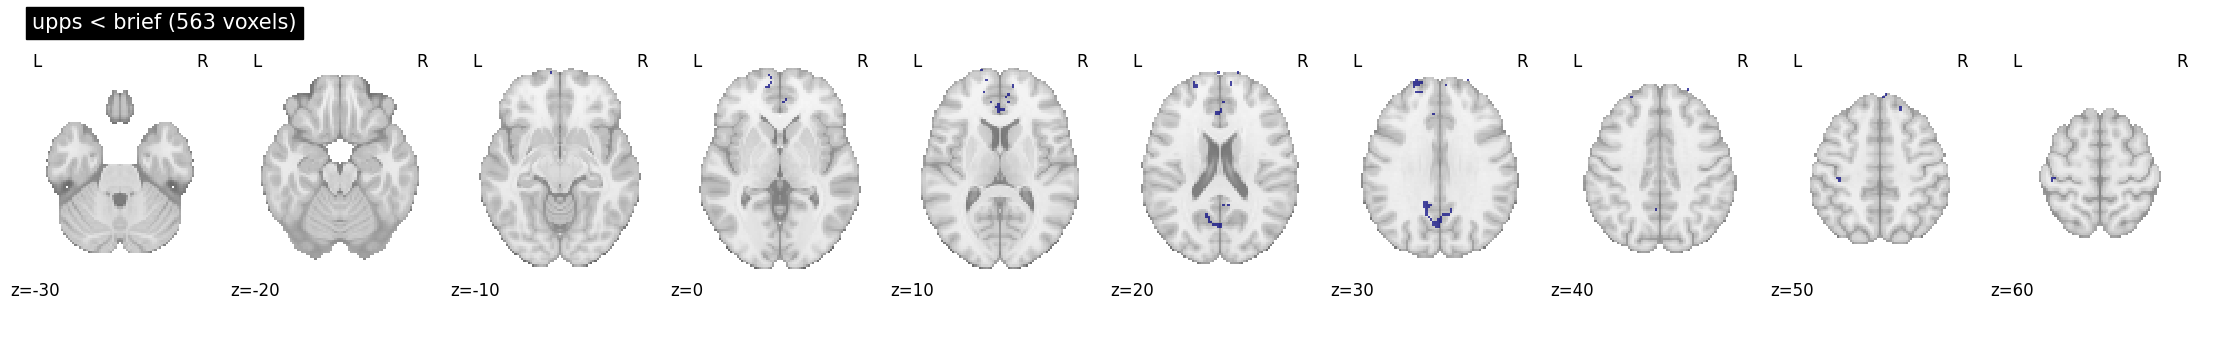

Integer 4160: 523 voxels -> ['brief > upps', 'future_time > upps'] (largest cluster: 214)


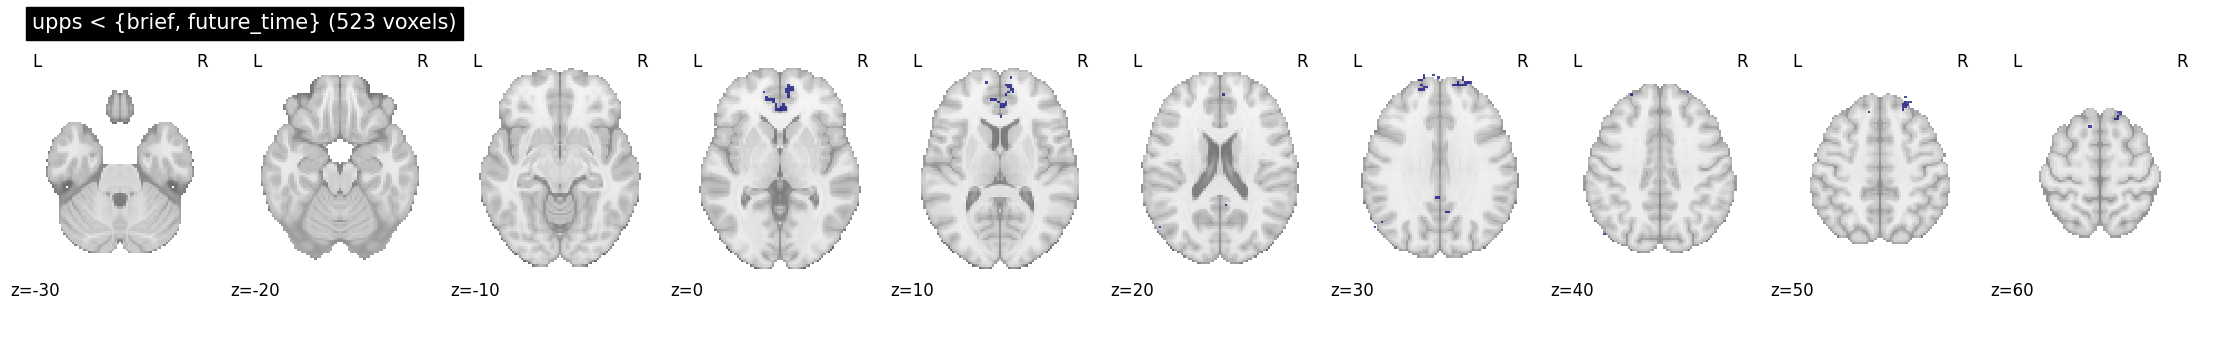

Integer 32768: 2183 voxels -> ['grit < impulsive_venture'] (largest cluster: 270)


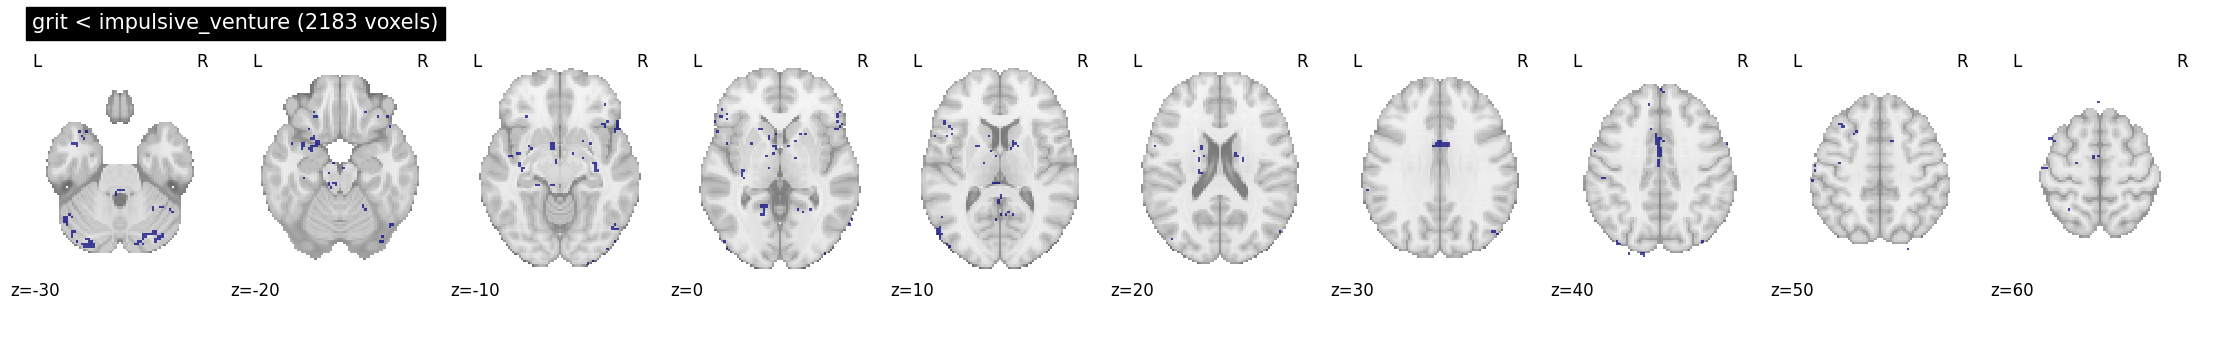

Integer 32800: 2163 voxels -> ['brief < impulsive_venture', 'grit < impulsive_venture'] (largest cluster: 239)


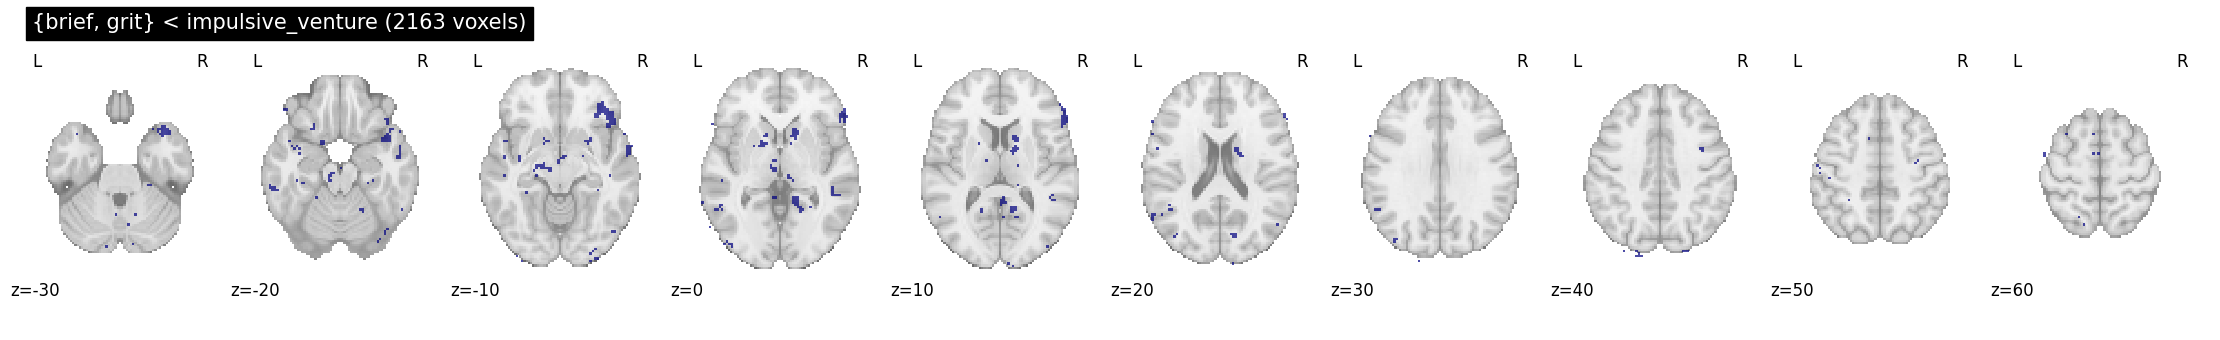

Integer 34848: 2427 voxels -> ['brief < impulsive_venture', 'future_time < impulsive_venture', 'grit < impulsive_venture'] (largest cluster: 204)


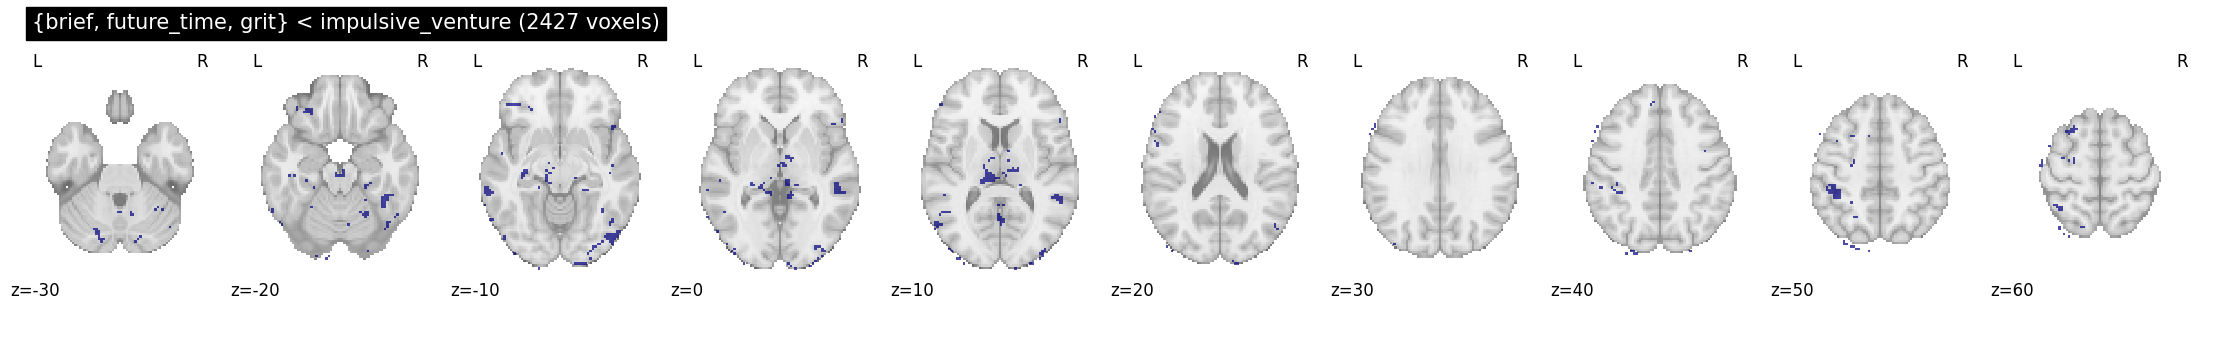

Integer 69696: 341 voxels -> ['brief > upps', 'future_time > upps', 'grit > upps'] (largest cluster: 250)


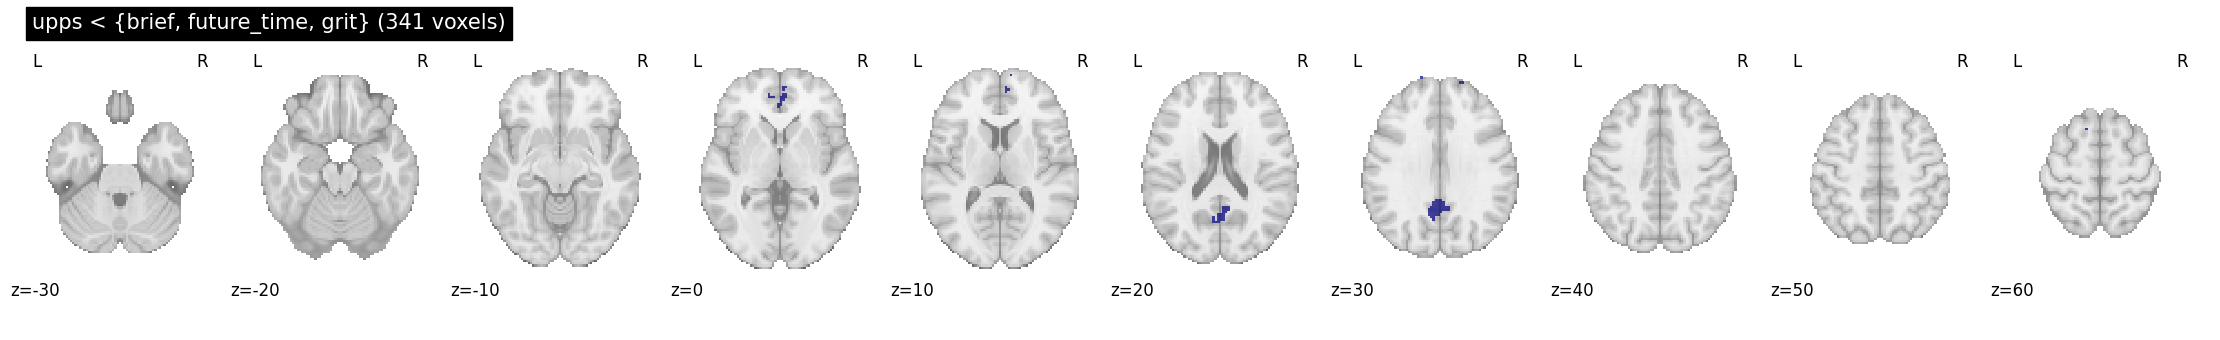

Integer 139392: 5631 voxels -> ['brief < upps', 'future_time < upps', 'grit < upps'] (largest cluster: 1160)


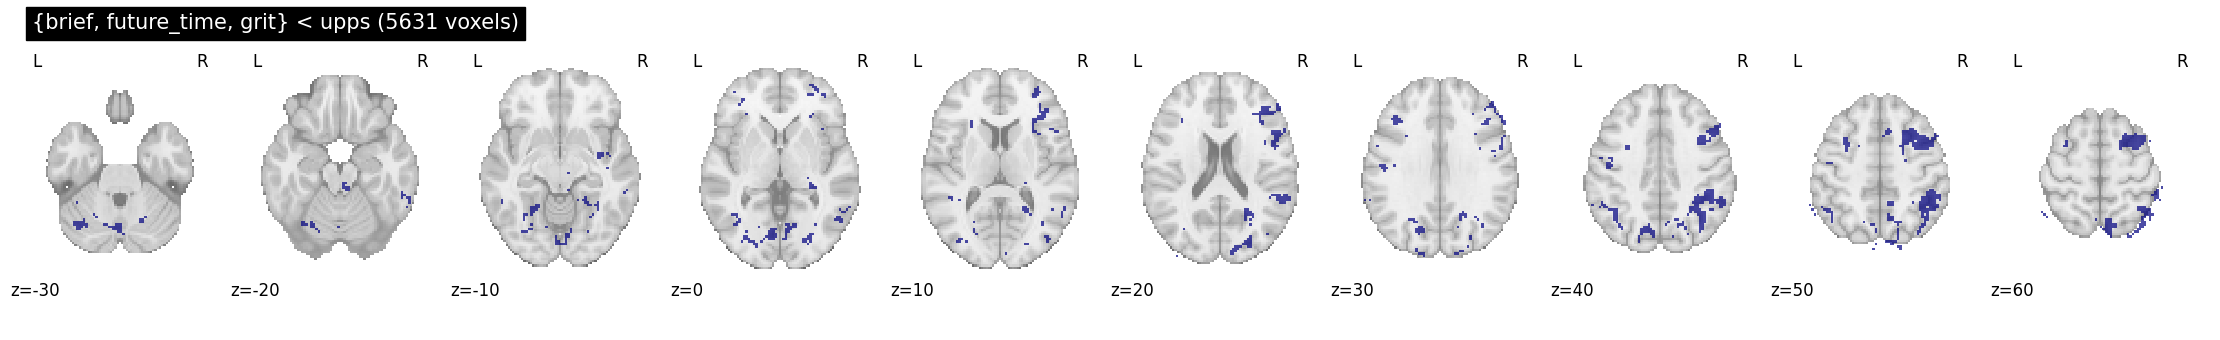

Integer 174240: 11997 voxels -> ['brief < impulsive_venture', 'brief < upps', 'future_time < impulsive_venture', 'future_time < upps', 'grit < impulsive_venture', 'grit < upps'] (largest cluster: 7094)


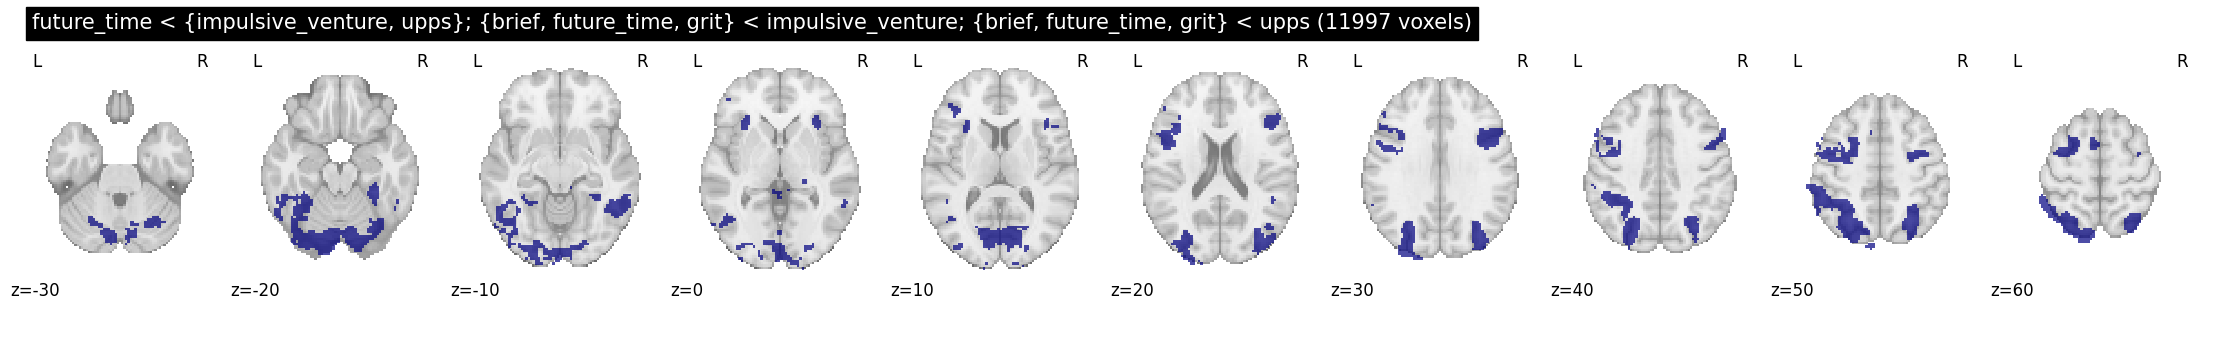

Integer 294912: 914 voxels -> ['grit < impulsive_venture', 'impulsive_venture > upps'] (largest cluster: 214)


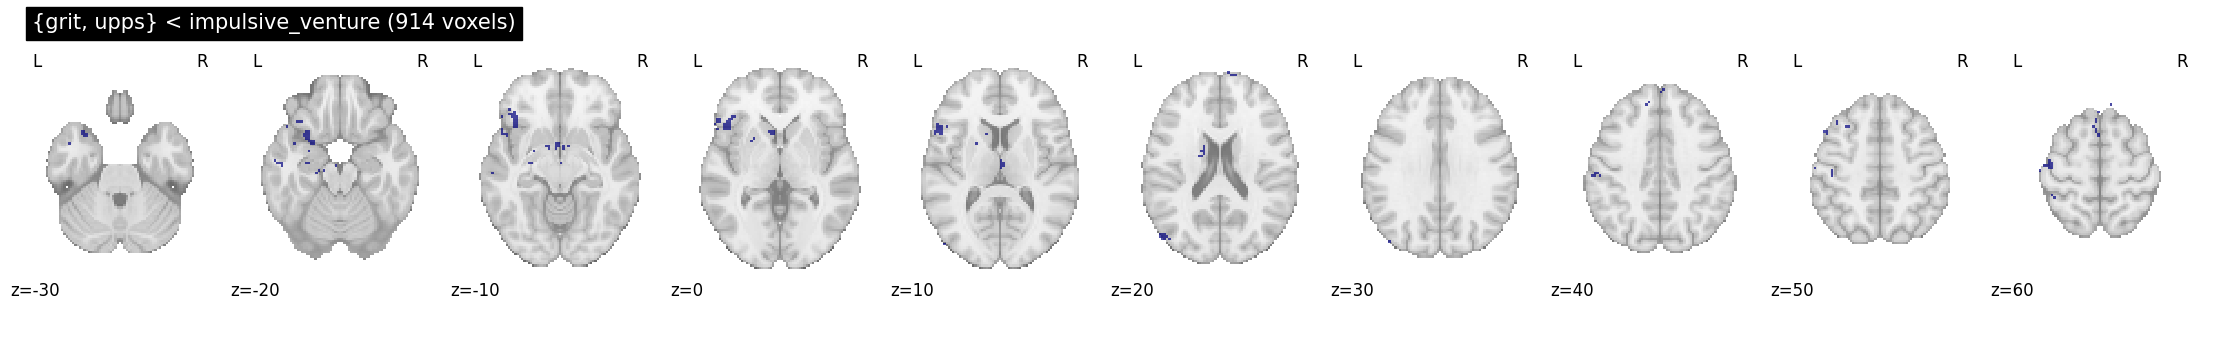

Integer 296992: 2438 voxels -> ['brief < impulsive_venture', 'future_time < impulsive_venture', 'grit < impulsive_venture', 'impulsive_venture > upps'] (largest cluster: 300)


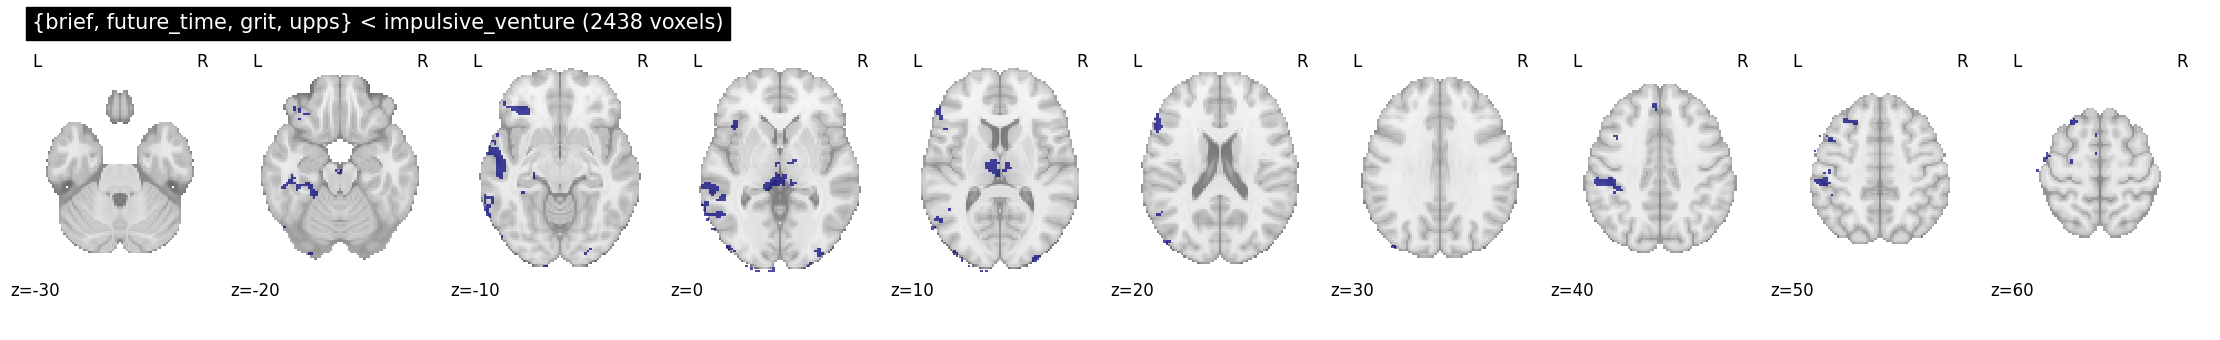

Integer 297120: 534 voxels -> ['brief < impulsive_venture', 'brief < upps', 'future_time < impulsive_venture', 'grit < impulsive_venture', 'impulsive_venture > upps'] (largest cluster: 242)


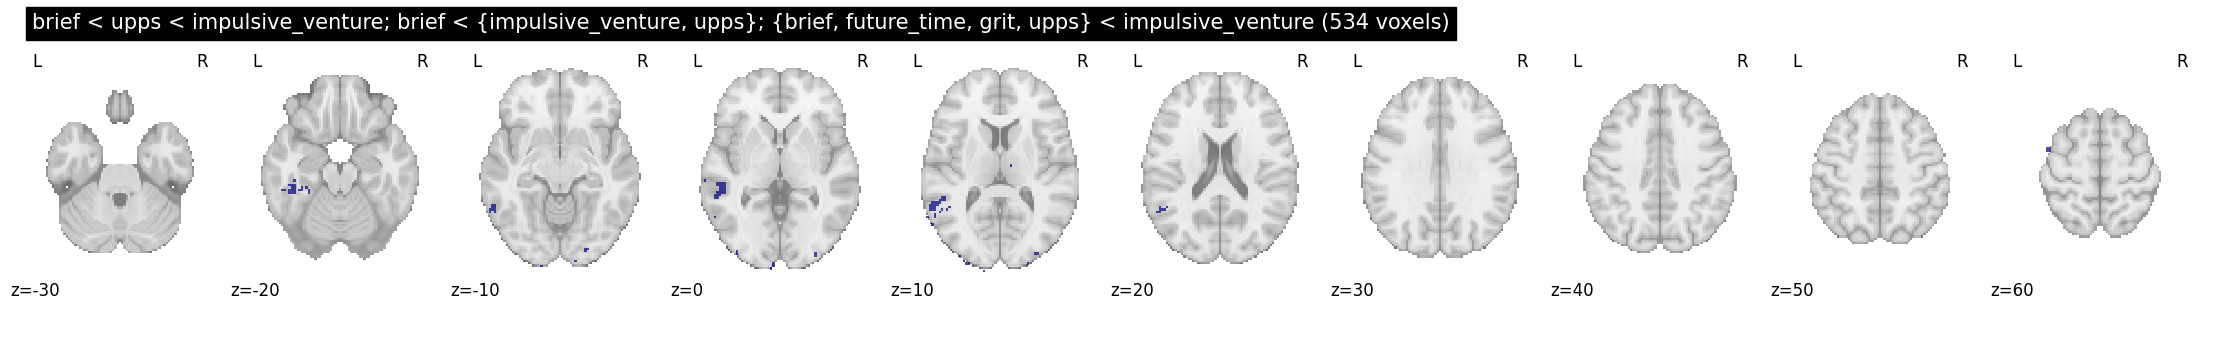

Integer 331840: 1044 voxels -> ['brief > upps', 'future_time > upps', 'grit > upps', 'impulsive_venture > upps'] (largest cluster: 743)


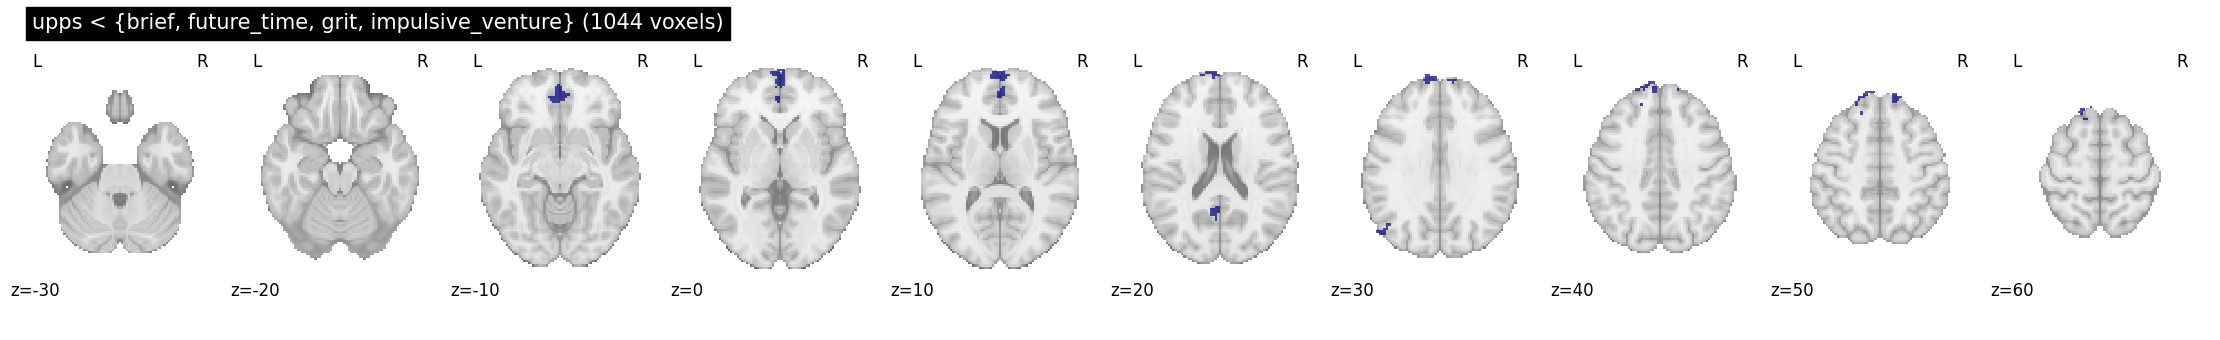

Integer 331844: 345 voxels -> ['brief > grit', 'brief > upps', 'future_time > upps', 'grit > upps', 'impulsive_venture > upps'] (largest cluster: 255)


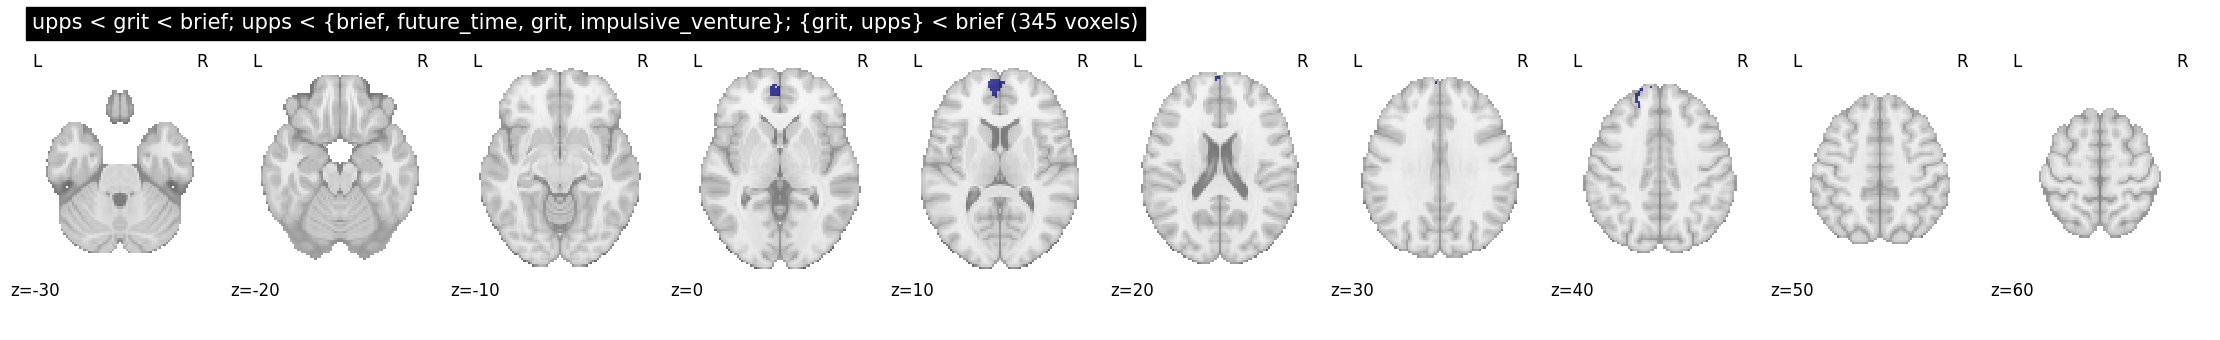

Integer 436384: 1615 voxels -> ['brief < impulsive_venture', 'brief < upps', 'future_time < impulsive_venture', 'future_time < upps', 'grit < impulsive_venture', 'grit < upps', 'impulsive_venture > upps'] (largest cluster: 548)


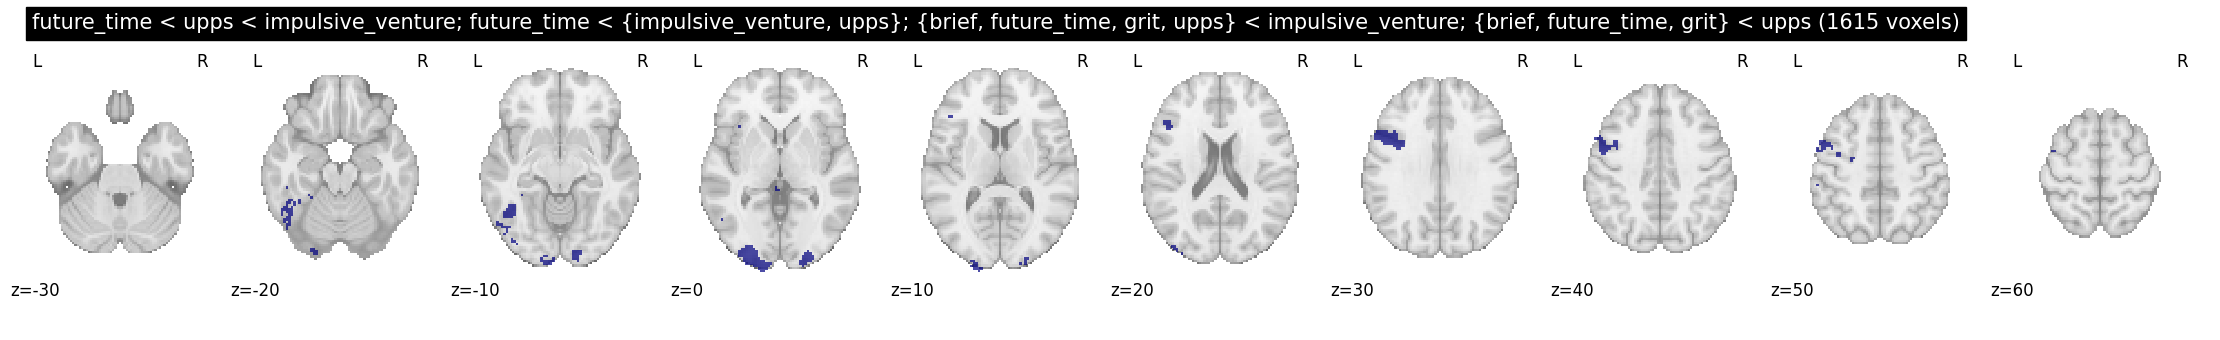

Integer 663680: 1859 voxels -> ['brief < upps', 'future_time < upps', 'grit < upps', 'impulsive_venture < upps'] (largest cluster: 547)


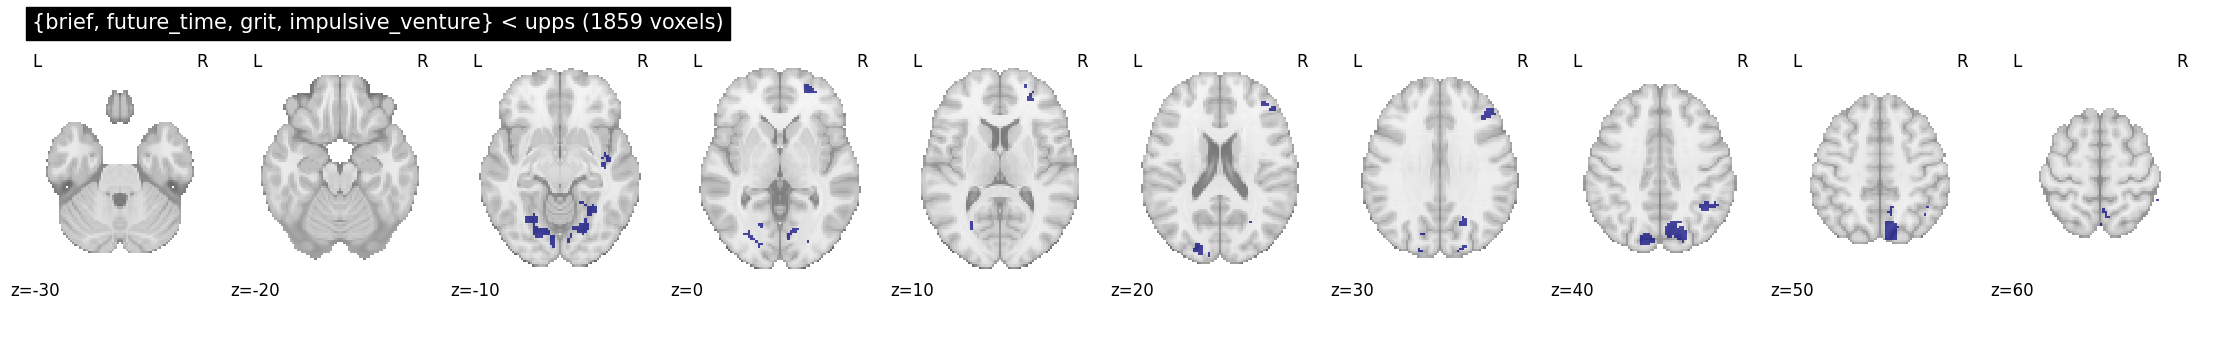

In [16]:
# Example inside your loop
for val, n_vox in voxel_counts.items():
    if val == 0:
        continue  # skip F-only (0)

    # Create a binary map for this integer
    data = (integer_map == val).astype(np.int32)

    # Label connected components
    labeled_array, num_features = label(data)  # 6-connectivity by default for 3D

    # Compute size of each connected component
    component_sizes = np.bincount(labeled_array.ravel())[1:]  # skip background (0)

    # Only plot if any component has at a minimum size
    if component_sizes.size == 0 or component_sizes.max() < 200:
        continue

    img_val = new_img_like(integer_img, data)
    # label_text = ', '.join(interpret_dict[val])
    label_text = generate_summary_title(interpret_dict[val])
    print(
        f'Integer {val}: {n_vox} voxels -> {interpret_dict[val]} (largest cluster: {component_sizes.max()})'
    )

    display = plot_roi(
        img_val,
        display_mode='z',
        cut_coords=z_slices,
        title=f'{label_text} ({n_vox} voxels)',
        colorbar=False,
    )
    plt.show()
    display.close()
